In [62]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import math
import numpy as np
import cmdstanpy
import pandas as pd
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats

from plots import plot_posterior_time_series
from measurements import form_table, display_measurements
import distributions
import samples

# matplotlib.style.use('seaborn-poster')
matplotlib.style.use('ggplot')

## Population info

In [63]:
# worldometer.com, just took the current ones.  these numbers can be pretty approximate.
populations = {
    'Italy':60488135,
    'China':1435000000,
    'Korea, South':51256309,
    'Spain':46749498,
    'US':331002651,
    'Australia':25411689,
    'Iran':83671720,
    'France':65231249,
    'Germany':83706861,
    'India':1376085273,
    'Russia':145916728,
}

# Running simulations

The first step is to simulate a bunch of measurements to ensure our model is doing roughly what we expect.

In [64]:
sim_config = {
    'start_index':0,
    'start_at_infections':50,
    'start_at_deaths':5,
    'country':'Australia',
    'model_name':'sird_discrete_simulate.stan',
}

sim_day_count = 30
sim_y0 = np.array([sim_config['start_at_infections'], 10, sim_config['start_at_deaths']])
sim_data = {
    # These initial conditions can be drawn from actual data as desired
    'y0':sim_y0,
    'T':sim_day_count,
    'ts':list(range(0, sim_day_count)),
    'population':populations[sim_config['country']],
    'sigma_infected':2,
    'sigma_dead':1,
    'beta':0.12,
    'gamma':0.004,
    'zeta':0.001,
}

In [65]:
sim_model = cmdstanpy.CmdStanModel(stan_file=sim_config['model_name'])

sim_results = sim_model.sample(data=sim_data,
                       # show_progress='notebook',
                       # Use a fixed seed so that our runs are deterministic.
                       seed=2222,
                       # This computer has 24 cores/48 threads; 24 chains is plenty
                       cores=24,
                       chains=24,
                       # Make sure to get enough samples to avoid any diagnostic problems
                       iter_sampling=300,
                       fixed_param=True)

# Generate a run summary
_ = samples.run_validate_stan(sim_results, ())

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/peddie/programming/covid19-modelling/sird_discrete_simulate
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:start chain 5
INFO:cmdstanpy:start chain 6
INFO:cmdstanpy:start chain 7
INFO:cmdstanpy:start chain 8
INFO:cmdstanpy:start chain 9
INFO:cmdstanpy:start chain 10
INFO:cmdstanpy:start chain 11
INFO:cmdstanpy:start chain 12
INFO:cmdstanpy:start chain 13
INFO:cmdstanpy:start chain 14
INFO:cmdstanpy:start chain 15
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 16
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 17
INFO:cmdstanpy:start chain 18
INFO:cmdstanpy:start chain 19
INFO:cmdstanpy:start chain 20
INFO:cmdstanpy:start chain 21
INFO:cmdstanpy:start chain 22
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:start chain 23
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:start chain 24
INFO:cmdstanpy

This plot shows the simulated noisy measurements.

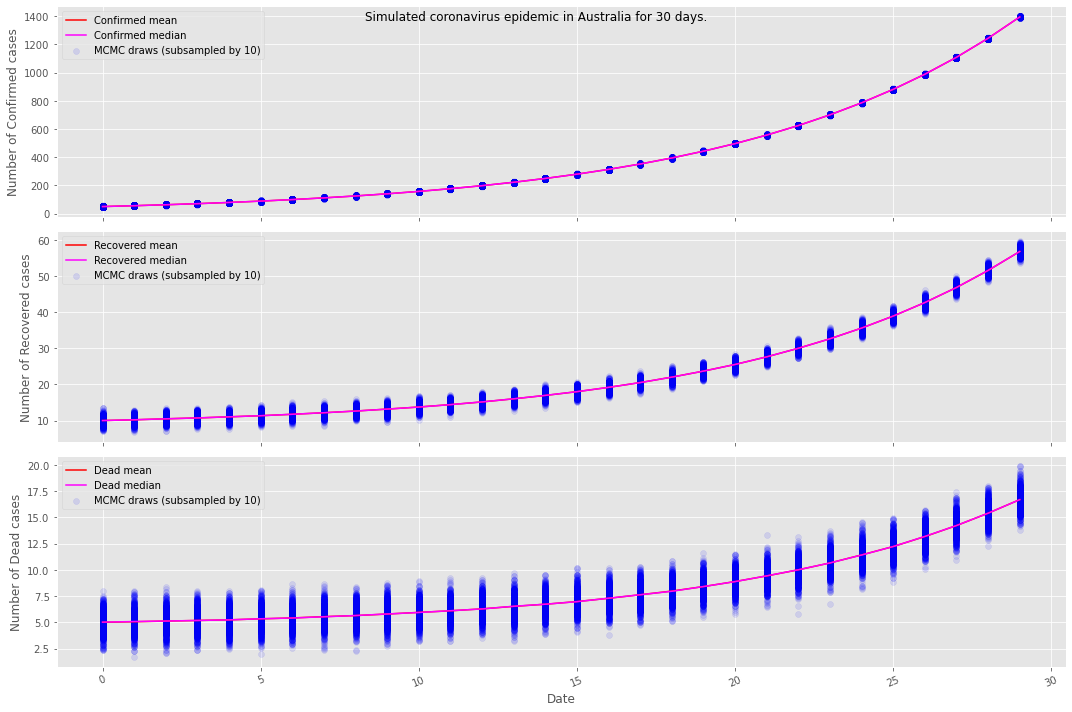

In [66]:
sim_samples = samples.get_sample_time_series(sim_results)
plot_posterior_time_series(sim_samples, None, sim_config, sample_points_only=True)

# Visualizing the prior

I heard that the prior can only be understood in the context of the likelihood.  Let's try to understand our prior.

It's handy to be able to visualize a few distributions when assigning priors.

e^(0.3 + 10^2/2) = 6.998620422451237e+21


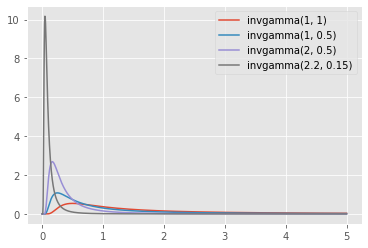

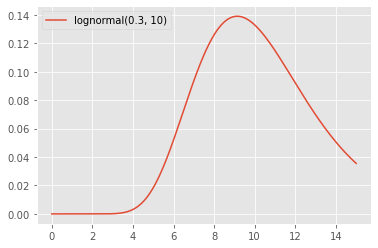

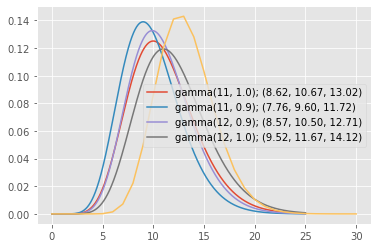

In [67]:
distributions.plot_invgammas([(1, 1), (1, 0.5), (2, 0.5), (2.2, 0.15)])
distributions.plot_lognormals([(0.3, 10)], window=15)
distributions.plot_gammas([(11, 1.0), (11, 0.9), (12, 0.9), (12, 1.0)], window=25)
xs = np.array([stats.gamma.pdf(x, 22, scale=0.6) for x in np.linspace(0, 30, 31)])
xs = xs / np.linalg.norm(xs, ord=1)
plt.plot(np.linspace(0, 30, 31), xs)

In [68]:
prior_data = {
    ## Parameters
    'y':sim_samples[0, :, :].transpose(),
    'T':sim_day_count,
    'ts':list(range(0, sim_day_count)),
    'population':populations[sim_config['country']],
    # inverse gamma
    'sigma_infected_prior':[2, 0.3],
    # inverse gamma
    'sigma_dead_prior':[2, 0.2],
    # inverse gamma
    'beta_prior':[0, 0.2],
    # normal
    'gamma_prior':[0, 1e-2],
    # normal
    'zeta_prior':[0, 1e-3],
    # fixed value
    'nu':9,
}

# We want to examine a run summary and look at posteriors and so on for these parameters
important_values = (
    'lp__',
    'beta',
    'gamma',
    'zeta',
    'sigma_infected',
    'sigma_dead',
) 

# We can't look for 'lp__' in the posterior stuff
analysis_variables=list(filter(lambda x: x != 'lp__', important_values))

See the comments about how to run the sampler.  We always generate a run summary every time we run this cell.  Its results should always be examined before proceeding to any other analysis.

In [69]:
prior_model = cmdstanpy.CmdStanModel(stan_file='sird_discrete_prior.stan')

prior_fit = prior_model.sample(data=prior_data,
                         show_progress='notebook',
                         # Use a fixed se|ed so that our runs are deterministic.
                         seed=2222,
                         # This computer has 24 cores/48 threads; 24 chains is plenty
                         cores=24,
                         chains=24,
                         # Make the sampler a bit more robust in exchange for more sampling time
                         adapt_delta=0.9,
                         # Let the sampler explore deeper
                         # max_treedepth=12,
                         # Make sure to get enough samples to avoid any diagnostic problems
                         iter_sampling=300)

# Generate a run summary
samples.run_validate_stan(prior_fit, important_values)


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/peddie/programming/covid19-modelling/sird_discrete_prior


INFO:cmdstanpy:Processing csv files: /tmp/tmpfwdi92do/sird_discrete_prior-202003291503-1-y_8q7c4k.csv, /tmp/tmpfwdi92do/sird_discrete_prior-202003291503-2-x3tolop1.csv, /tmp/tmpfwdi92do/sird_discrete_prior-202003291503-3-x7epcln3.csv, /tmp/tmpfwdi92do/sird_discrete_prior-202003291503-4-yo8m6o0e.csv, /tmp/tmpfwdi92do/sird_discrete_prior-202003291503-5-rrnx5hip.csv, /tmp/tmpfwdi92do/sird_discrete_prior-202003291503-6-udkia2k2.csv, /tmp/tmpfwdi92do/sird_discrete_prior-202003291503-7-lt569m93.csv, /tmp/tmpfwdi92do/sird_discrete_prior-202003291503-8-xby6wy09.csv, /tmp/tmpfwdi92do/sird_discrete_prior-202003291503-9-ih8lr0z9.csv, /tmp/tmpfwdi92do/sird_discrete_prior-202003291503-10-hjbq_5o7.csv, /tmp/tmpfwdi92do/sird_discrete_prior-202003291503-11-qzrdlpzv.csv, /tmp/tmpfwdi92do/sird_discrete_prior-202003291503-12-r5wultn4.csv, /tmp/tmpfwdi92do/sird_discrete_prior-202003291503-13-yw_0a3jf.csv, /tmp/tmpfwdi92do/sird_discrete_prior-202003291503-14-_sw3m53b.csv, /tmp/tmpfwdi92do/sird_discrete_pri

Mean      MCSE    StdDev         5%        50%  \
name                                                                  
lp__           -13.393900  0.038524  1.834780 -16.830100 -13.034300   
beta             0.161056  0.001481  0.120992   0.013985   0.134704   
gamma            0.008102  0.000078  0.006151   0.000676   0.006847   
zeta             0.000799  0.000009  0.000597   0.000067   0.000686   
sigma_infected   0.303924  0.011402  0.636272   0.062929   0.180283   
sigma_dead       0.201537  0.006333  0.366220   0.041880   0.121650   

                      95%    N_Eff   N_Eff/s    R_hat  
name                                                   
lp__           -11.124200  2268.38   633.633  1.01035  
beta             0.393799  6674.05  1864.280  1.00062  
gamma            0.020074  6241.30  1743.400  0.99958  
zeta             0.001927  4565.91  1275.410  1.00201  
sigma_infected   0.855101  3114.14   869.880  1.00481  
sigma_dead       0.570025  3343.47   933.938  1.00257

## Prior visualization and analysis

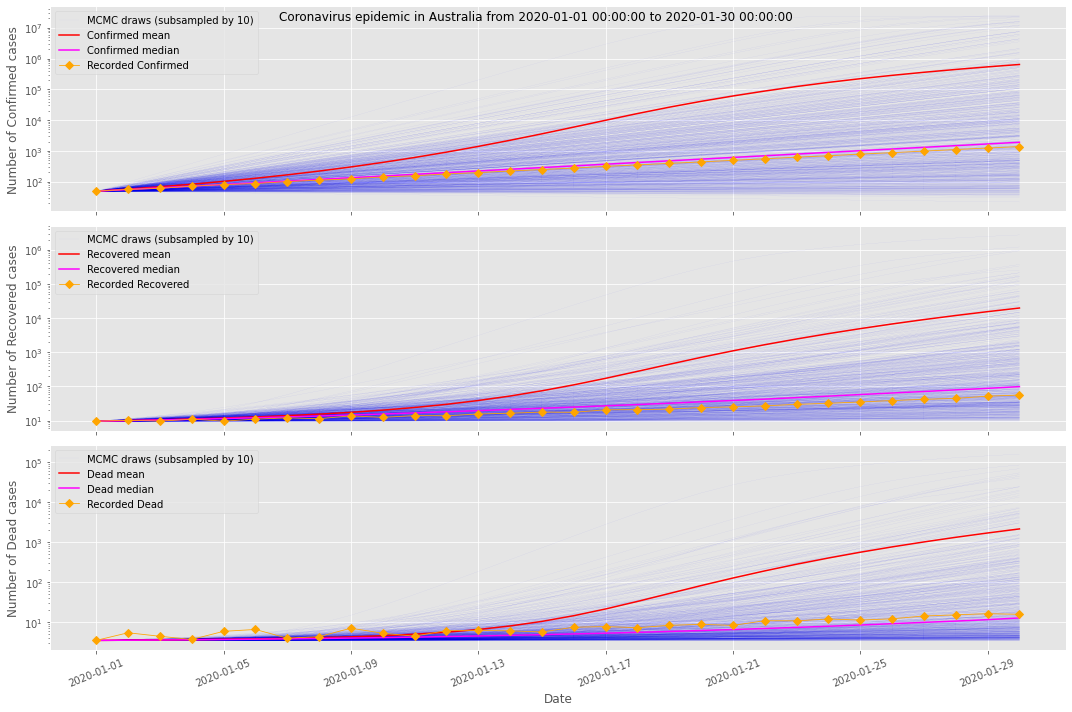

-127026715617550.03 0


In [70]:
prior_samples = samples.get_sample_time_series(prior_fit)
sim_comparison = pd.DataFrame(sim_samples[0, :, :].transpose(), 
                              index=pd.date_range(start='1/1/20', periods=sim_day_count),
                              columns=['Confirmed', 'Recovered', 'Dead'])
plot_posterior_time_series(prior_samples, sim_comparison, sim_config, plot_log=True)
log_likelihoods = samples.compute_sample_log_likelihood(prior_fit)
print(np.mean(log_likelihoods), np.count_nonzero(np.isnan(log_likelihoods)))

#### Extended prior diagnostics

We'll use arviz to do some more diagnostic plots.

Displaying posterior plots.


/usr/local/lib/python3.8/dist-packages/arviz/plots/backends/matplotlib/pairplot.py:129: MatplotlibDeprecationWarning: In a future version, 'pad' will default to rcParams['figure.subplot.wspace'].  Set pad=0 to keep the old behavior.
  cax = divider.append_axes("left", size="7%")


Validating inference run.


/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:732: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:531: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:732: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:732: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


LOO analysis:
 Computed from 7200 by 90 log-likelihood matrix

         Estimate       SE
elpd_loo -12765322920367032.00  5391346470114306.00
p_loo    12765322920366602.00        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        2    2.2%
 (0.5, 0.7]   (ok)          1    1.1%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)   87   96.7%

Validating parameter sampling.


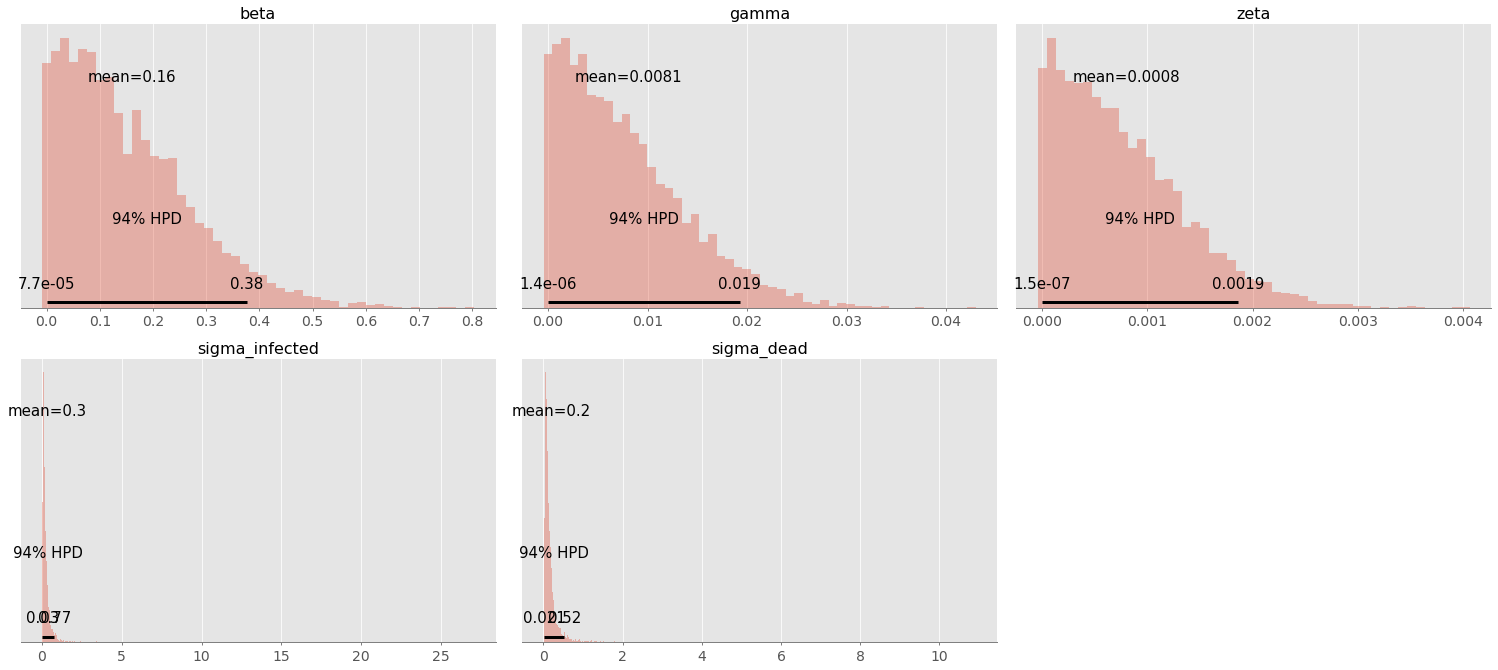

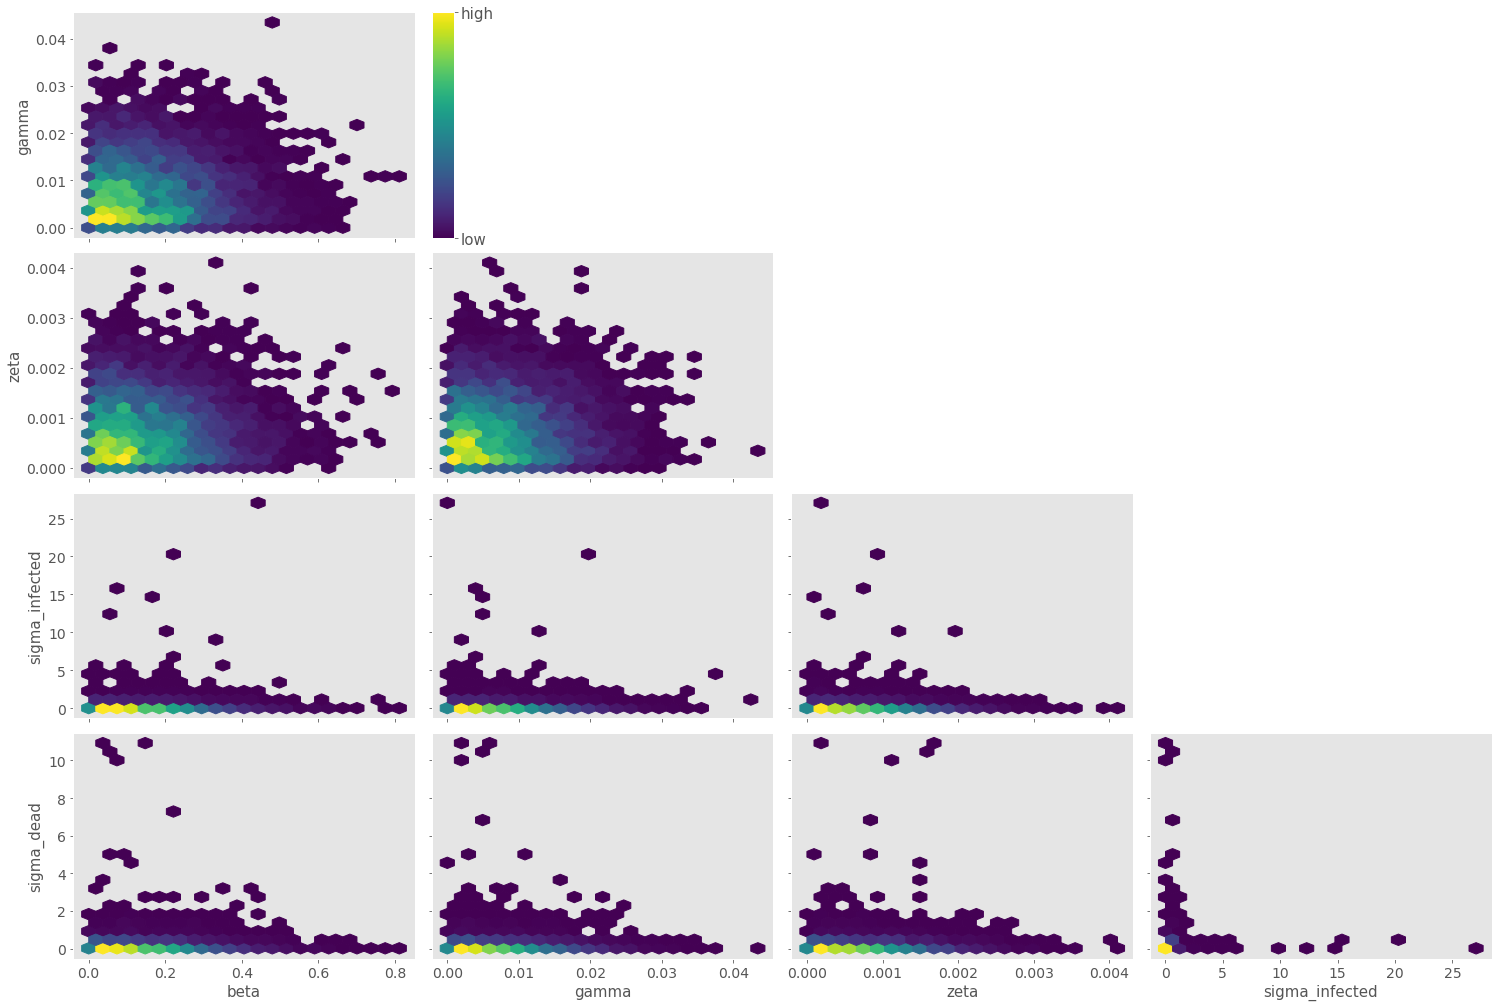

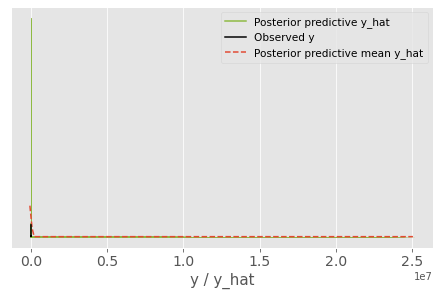

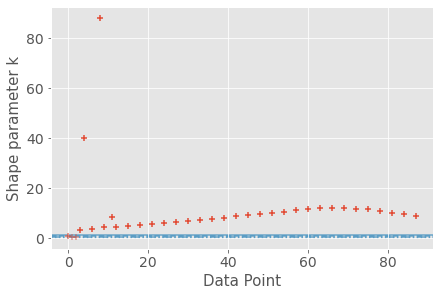

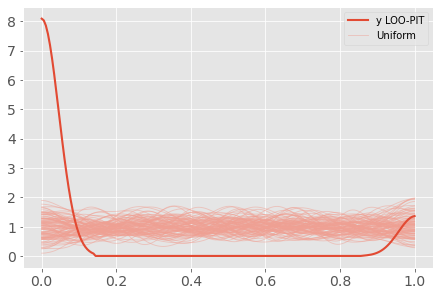

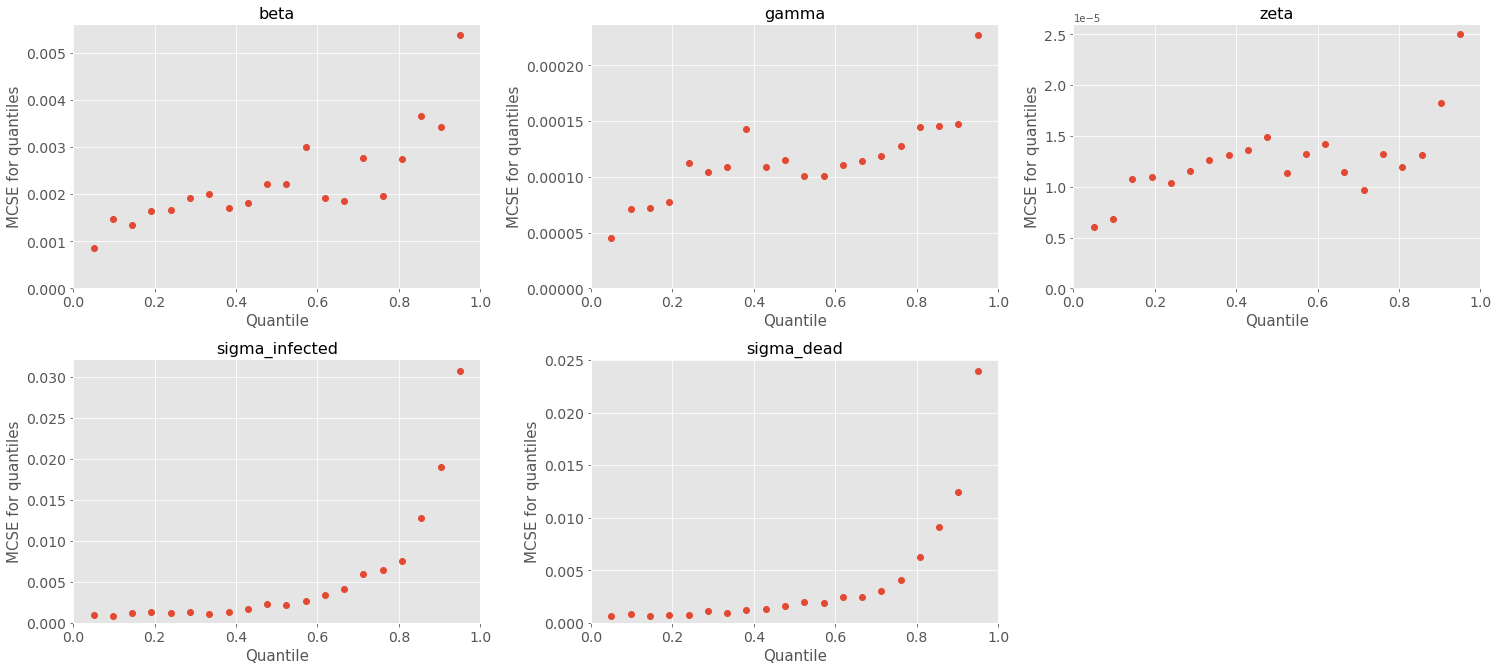

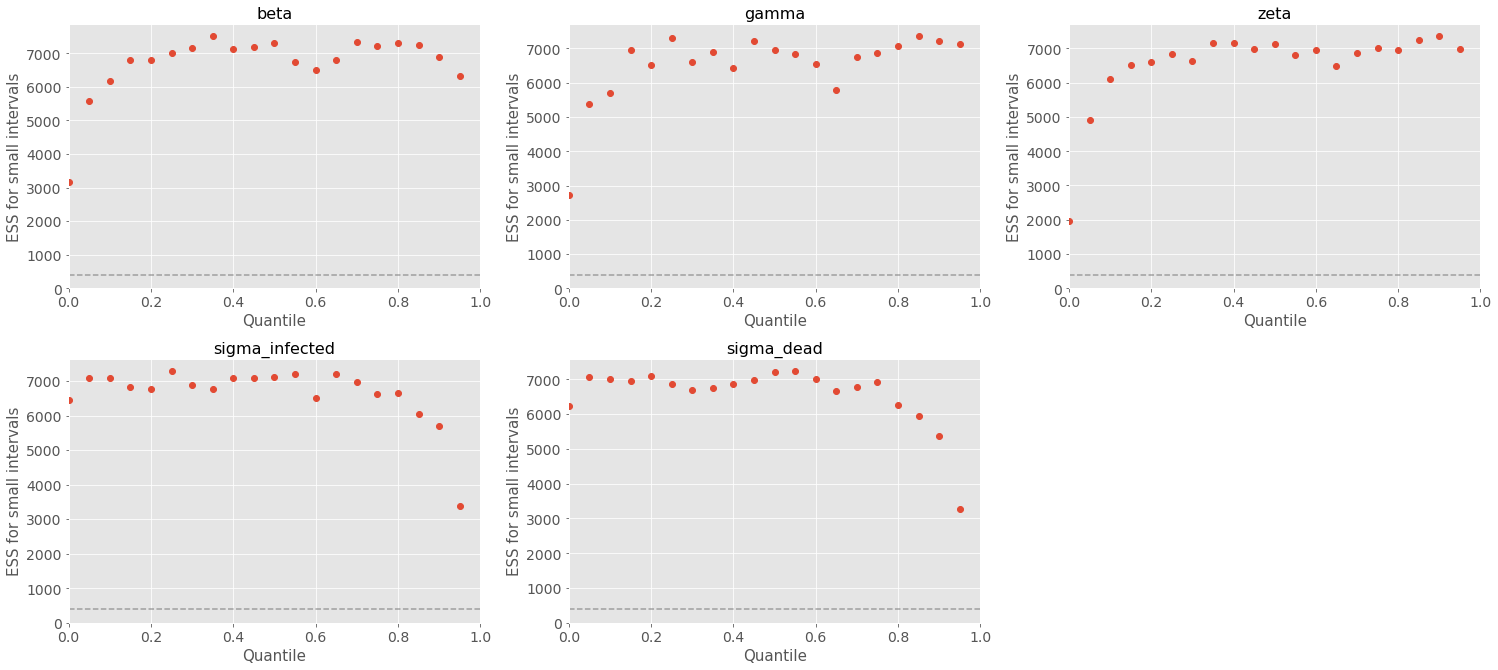

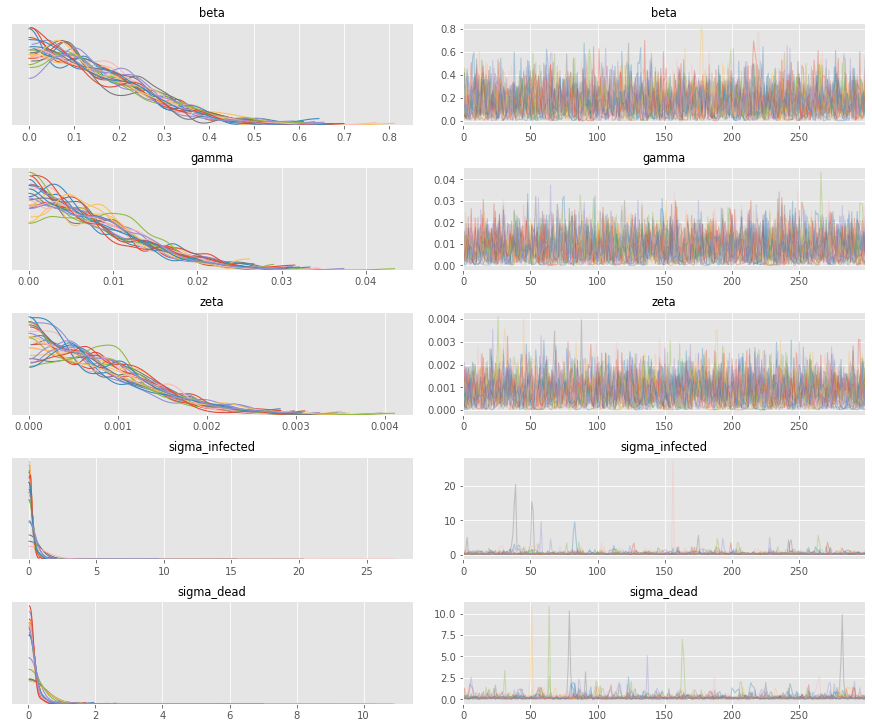

In [71]:
# TODO(MP): how do you plot log probability of the sample?  'lp__' is gone.
analysis_variables=list(filter(lambda x: x != 'lp__', important_values))
samples.standard_validate_arviz(prior_fit, 'log_likelihood', 'y_hat', sim_comparison.to_numpy(), analysis_variables)

# Inference on simulated data

This is the real test.

In [72]:
sim_fit_model = cmdstanpy.CmdStanModel(stan_file='sird_discrete.stan')

sim_fit = sim_fit_model.sample(data=prior_data,
                               show_progress='notebook',
                               # Use a fixed seed so that our runs are deterministic.
                               seed=2222,
                               # This computer has 24 cores/48 threads; 24 chains is plenty
                               cores=24,
                               chains=24,
                               # Make the sampler a bit more robust in exchange for more sampling time
                               adapt_delta=0.9,
                               # Let the sampler explore deeper
                               # max_treedepth=12,
                               # Make sure to get enough samples to avoid any diagnostic problems
                               iter_sampling=300)

# Generate a run summary
samples.run_validate_stan(sim_fit, important_values)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/peddie/programming/covid19-modelling/sird_discrete


INFO:cmdstanpy:Processing csv files: /tmp/tmpfwdi92do/sird_discrete-202003291504-1-10c92o6r.csv, /tmp/tmpfwdi92do/sird_discrete-202003291504-2-lqbgyuc5.csv, /tmp/tmpfwdi92do/sird_discrete-202003291504-3-qg40s99m.csv, /tmp/tmpfwdi92do/sird_discrete-202003291504-4-5tbpuzcn.csv, /tmp/tmpfwdi92do/sird_discrete-202003291504-5-87_5go1h.csv, /tmp/tmpfwdi92do/sird_discrete-202003291504-6-o5dlog7h.csv, /tmp/tmpfwdi92do/sird_discrete-202003291504-7-li0vd76z.csv, /tmp/tmpfwdi92do/sird_discrete-202003291504-8-v43yscjo.csv, /tmp/tmpfwdi92do/sird_discrete-202003291504-9-0qka0ml6.csv, /tmp/tmpfwdi92do/sird_discrete-202003291504-10-4bd9it88.csv, /tmp/tmpfwdi92do/sird_discrete-202003291504-11-tshj8i7f.csv, /tmp/tmpfwdi92do/sird_discrete-202003291504-12-pl52x17r.csv, /tmp/tmpfwdi92do/sird_discrete-202003291504-13-des8hu0b.csv, /tmp/tmpfwdi92do/sird_discrete-202003291504-14-hwwdpzg6.csv, /tmp/tmpfwdi92do/sird_discrete-202003291504-15-aiwh0yey.csv, /tmp/tmpfwdi92do/sird_discrete-202003291504-16-ngykibsp.c

Mean          MCSE    StdDev         5%        50%  \
name                                                                      
lp__           -90.933500  3.098730e-02  1.619680 -94.026800 -90.631100   
beta             0.120749  8.881940e-07  0.000068   0.120637   0.120749   
gamma            0.003998  5.807750e-07  0.000042   0.003927   0.003999   
zeta             0.001257  5.962980e-07  0.000042   0.001188   0.001257   
sigma_infected   2.124060  4.465940e-03  0.314886   1.665320   2.090380   
sigma_dead       1.040320  1.434520e-03  0.097421   0.894799   1.032150   

                      95%    N_Eff  N_Eff/s    R_hat  
name                                                  
lp__           -88.945200  2732.05  310.327  1.00744  
beta             0.120862  5851.70  664.681  1.00078  
gamma            0.004066  5236.18  594.765  1.00134  
zeta             0.001326  4940.74  561.207  1.00180  
sigma_infected   2.685040  4971.44  564.693  1.00063  
sigma_dead       1.212770  4612.03  523.869  1.00133

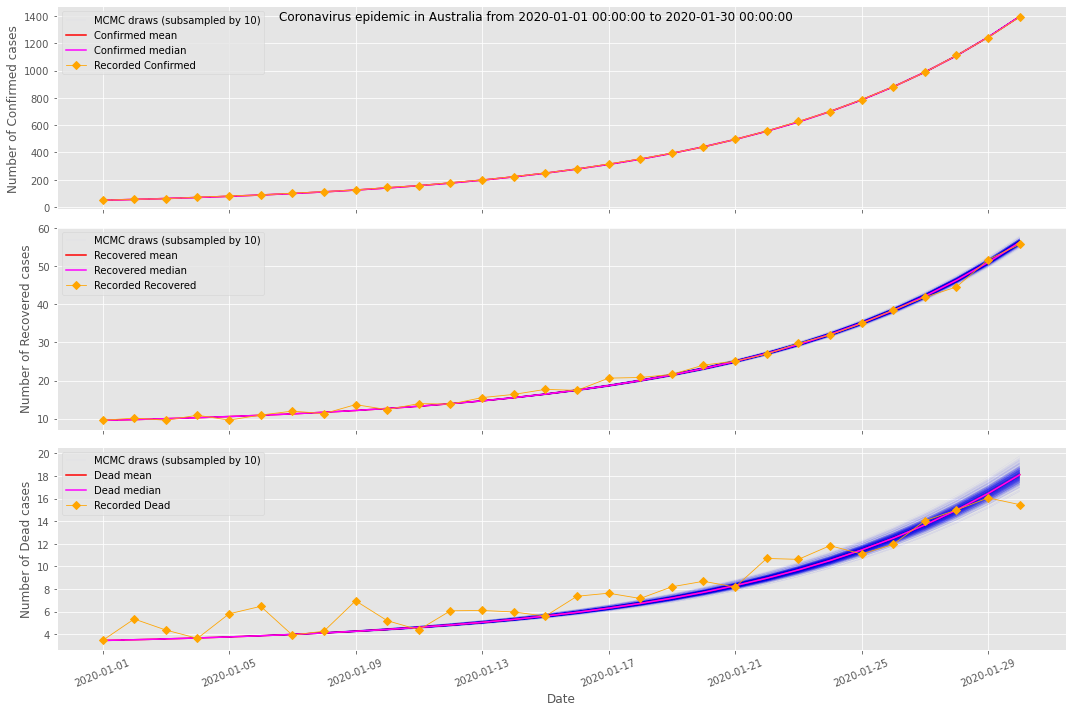

In [73]:
sim_fit_samples = samples.get_sample_time_series(sim_fit)
plot_posterior_time_series(sim_fit_samples, sim_comparison, sim_config)

In [74]:
sim_fit_summary = sim_fit.summary()
print("Errors in inference from simulated data:")
errors = pd.DataFrame(([sim_data[varname],
                        sim_fit_summary.loc[varname, 'Mean'],
                        np.abs(sim_data[varname] - sim_fit_summary.loc[varname, 'Mean'])]
                       for varname in analysis_variables),
                      columns=['Simulated value', 'Posterior mean', 'Error'],
                      index=analysis_variables)
print(errors)

def sir_r0(fit):
    beta = fit.loc['beta', 'Mean']
    gamma = fit.loc['gamma', 'Mean']
    print(f'R0 = {beta} / {gamma} = {beta / gamma}')
    return beta, gamma

sir_r0(sim_fit_summary)

Errors in inference from simulated data:
                Simulated value  Posterior mean     Error
beta                      0.120        0.120749  0.000749
gamma                     0.004        0.003998  0.000002
zeta                      0.001        0.001257  0.000257
sigma_infected            2.000        2.124060  0.124060
sigma_dead                1.000        1.040320  0.040320
R0 = 0.120749 / 0.00399796 = 30.202653353210135


(0.120749, 0.00399796)

#### Extended prior diagnostics

We'll use arviz to do some more diagnostic plots.

Displaying posterior plots.


/usr/local/lib/python3.8/dist-packages/arviz/plots/backends/matplotlib/pairplot.py:129: MatplotlibDeprecationWarning: In a future version, 'pad' will default to rcParams['figure.subplot.wspace'].  Set pad=0 to keep the old behavior.
  cax = divider.append_axes("left", size="7%")


Validating inference run.
LOO analysis:
 Computed from 7200 by 90 log-likelihood matrix

         Estimate       SE
elpd_loo  -161.16     8.99
p_loo        7.05        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       89   98.9%
 (0.5, 0.7]   (ok)          1    1.1%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

Validating parameter sampling.


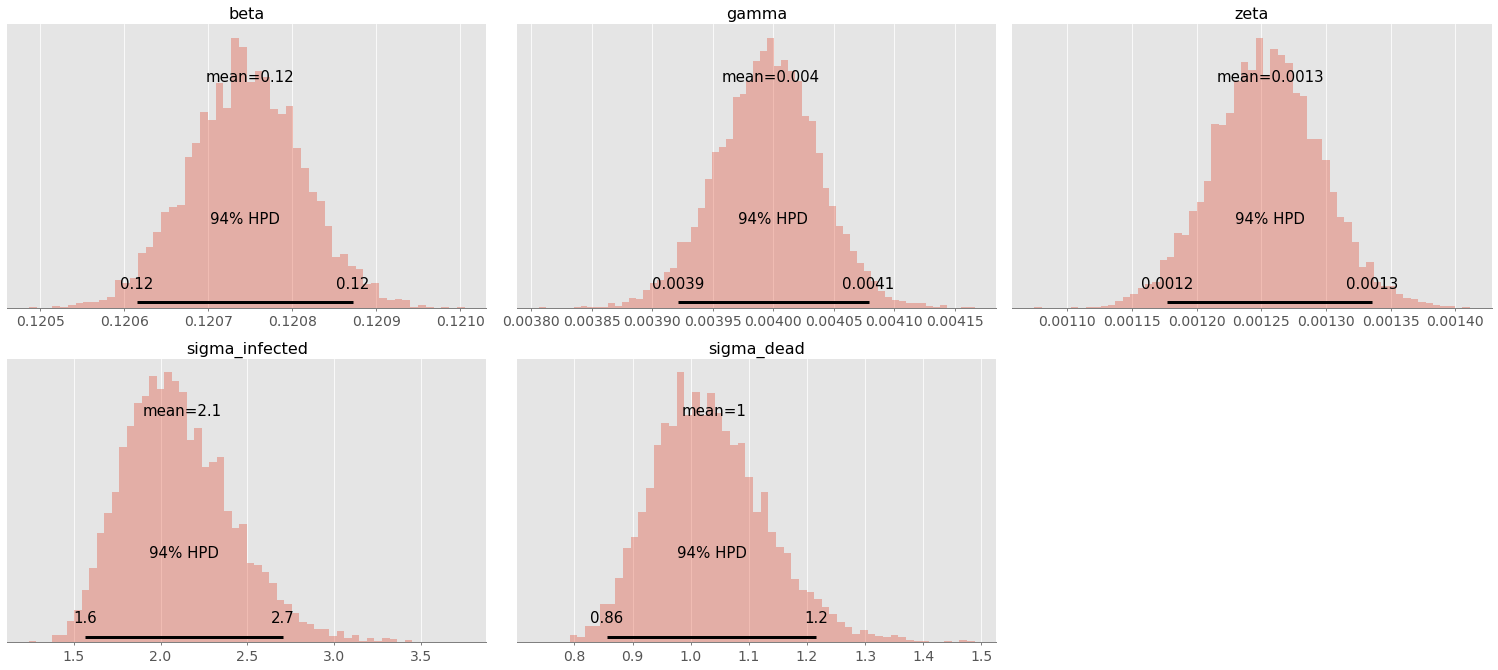

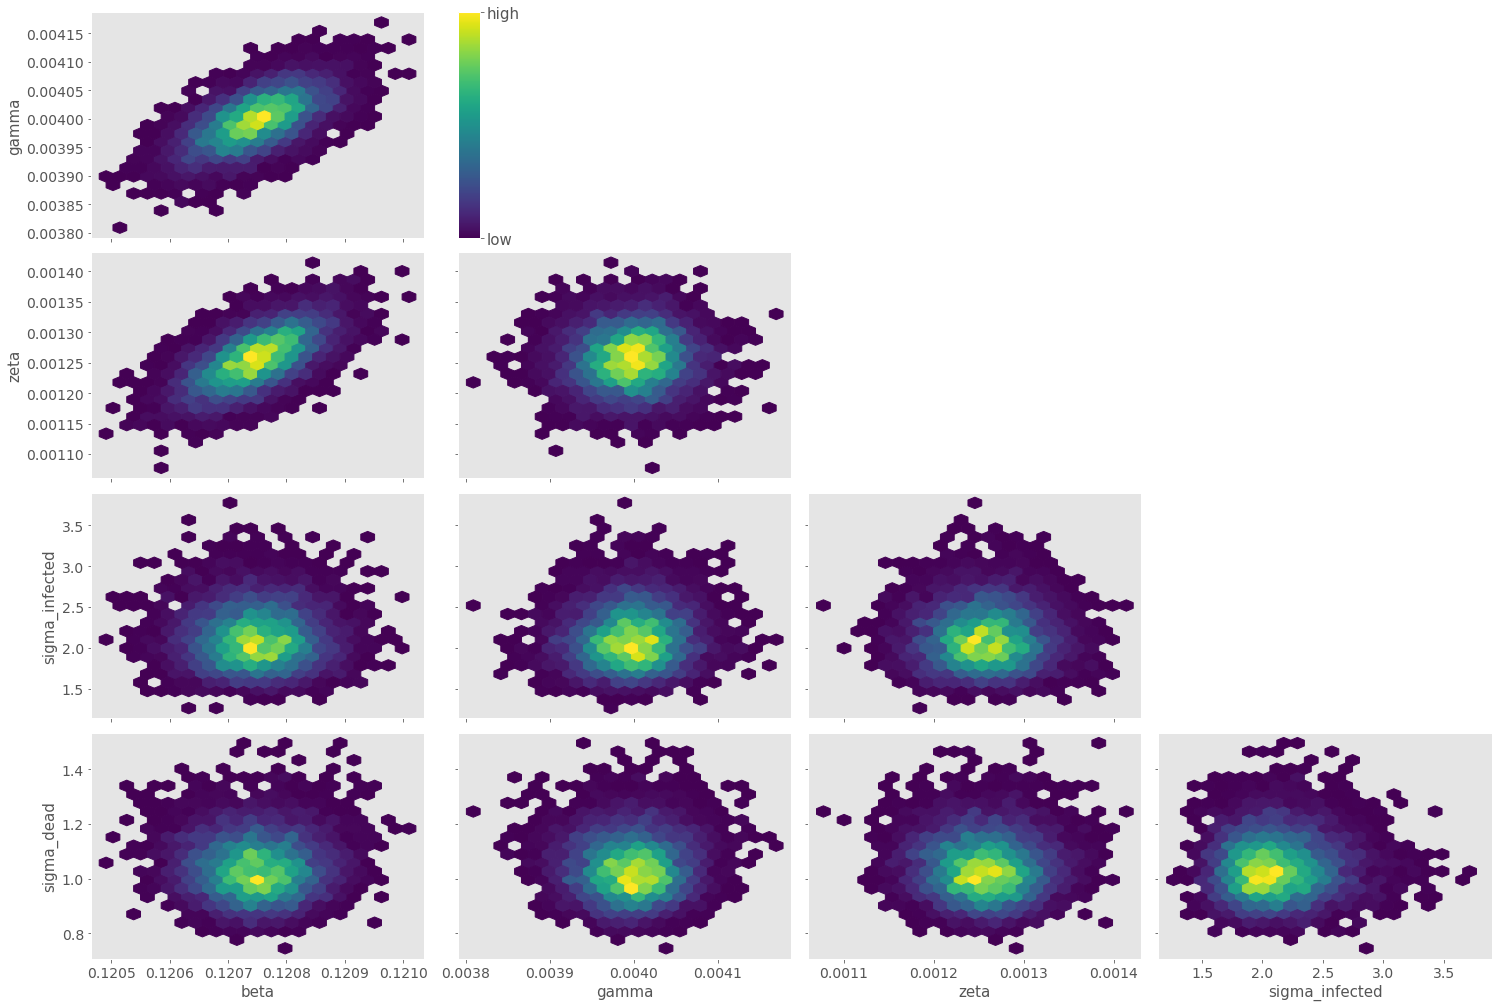

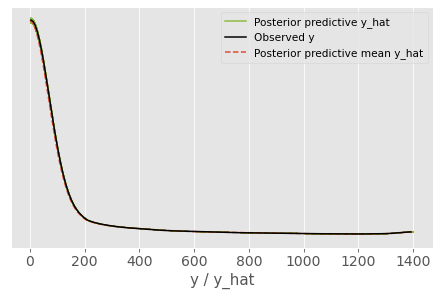

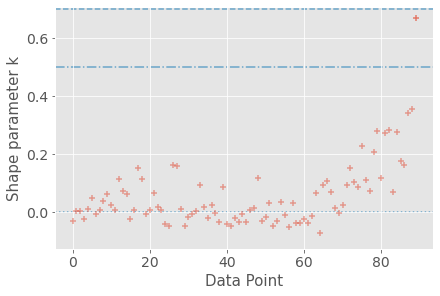

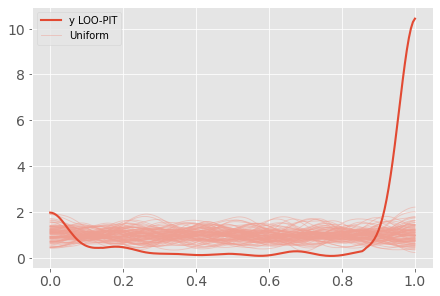

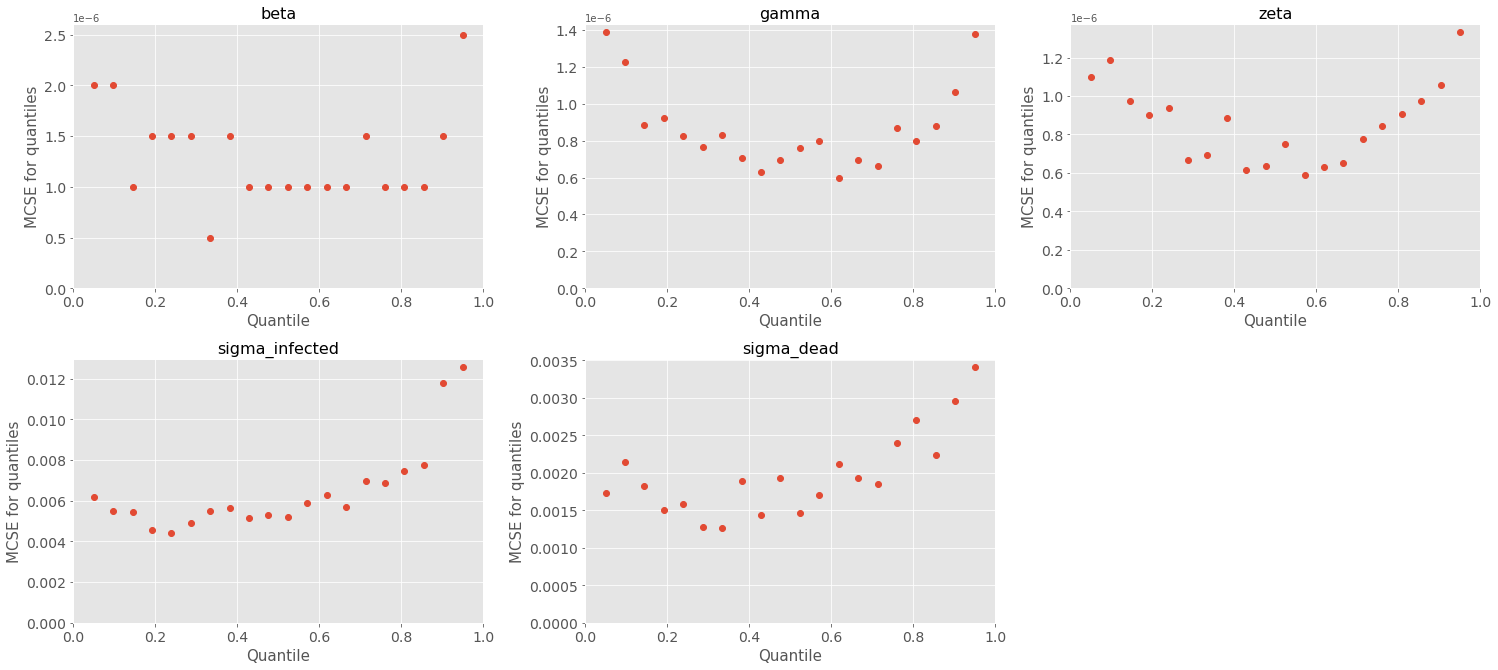

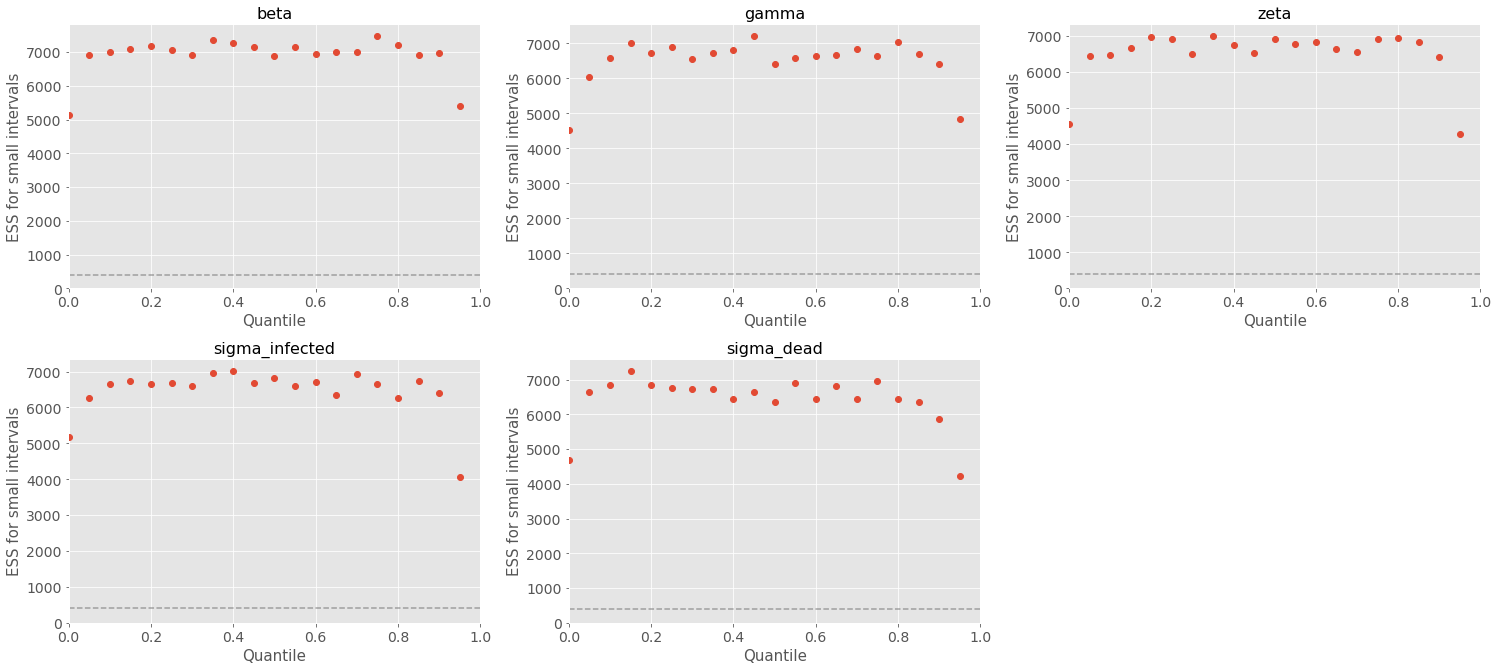

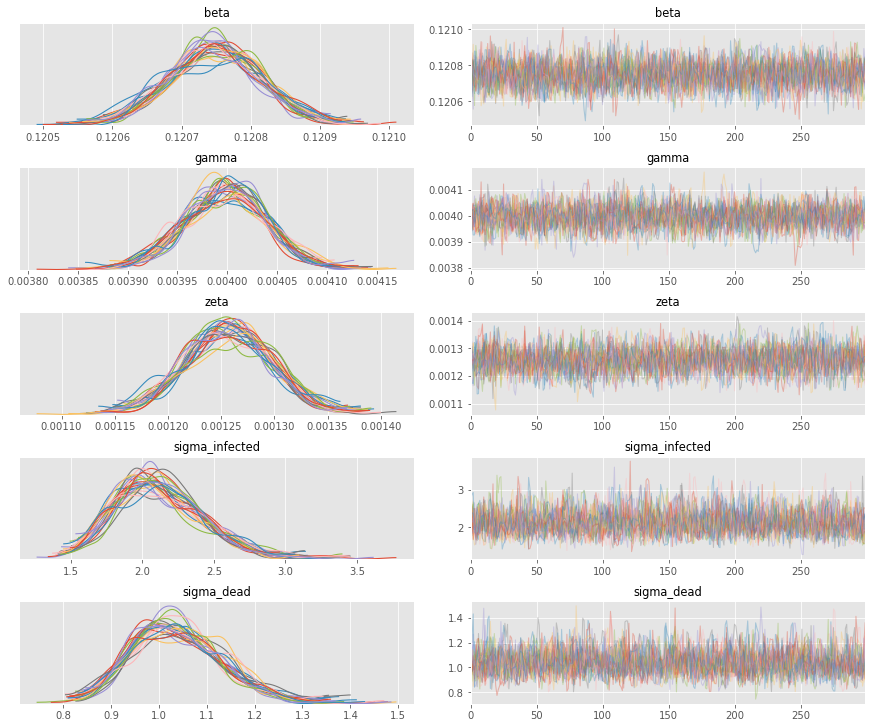

In [75]:
samples.standard_validate_arviz(sim_fit, 'log_likelihood', 'y_hat', sim_comparison.to_numpy(), analysis_variables)

# Inference from data

## Fetch the latest data on the epidemic

In [76]:
curl = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
durl = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
rurl = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

confirmed = pd.read_csv(curl, error_bad_lines=False)
dead = pd.read_csv(durl, error_bad_lines=False)
recovered = pd.read_csv(rurl, error_bad_lines=False)

data_start_index = '1/22/20'

Let's check out some of the earliest data sets.

In [77]:
def subset_country_names(table, countries):
    rose = []
    for country in countries:
        rose.append(confirmed[confirmed['Country/Region'] == country])
    return pd.concat(rose, axis=0)

subset_country_names(confirmed, ['Italy', 'Spain', 'Korea, South', 'Iran'])

Province/State Country/Region   Lat   Long  1/22/20  1/23/20  1/24/20  \
137            NaN          Italy  43.0   12.0        0        0        0   
201            NaN          Spain  40.0   -4.0        0        0        0   
143            NaN   Korea, South  36.0  128.0        1        1        2   
133            NaN           Iran  32.0   53.0        0        0        0   

     1/25/20  1/26/20  1/27/20  ...  3/19/20  3/20/20  3/21/20  3/22/20  \
137        0        0        0  ...    41035    47021    53578    59138   
201        0        0        0  ...    17963    20410    25374    28768   
143        2        3        4  ...     8565     8652     8799     8961   
133        0        0        0  ...    18407    19644    20610    21638   

     3/23/20  3/24/20  3/25/20  3/26/20  3/27/20  3/28/20  
137    63927    69176    74386    80589    86498    92472  
201    35136    39885    49515    57786    65719    73235  
143     8961     9037     9137     9241     9332     9478  
133    23049    24811    27017    29406    32332    35408  

[4 rows x 71 columns]

Configure the observations

In [88]:
data_config = {
    'start_index':data_start_index,
    'start_at_infections':40,
    'start_at_deaths':5,
    'country':'US',
    'model_file':'sird_discrete.stan',
}

## Extracting the time-series values

Here we'll pull out just the measurements we have for the specified country and organize them as a single matrix to feed into Stan.

In [89]:
measurements = form_table(data_config, confirmed, recovered, dead).iloc[0:-2, :]
day_count = measurements.shape[0]
measurements.iloc[0, :]

US reached 40 "Confirmed" on 2/24/20; dropping preceding data


Confirmed    46
Recovered     5
Dead          0
Name: 2/24/20, dtype: int64

It's always a good idea to take a look at the data we plan to fit to.

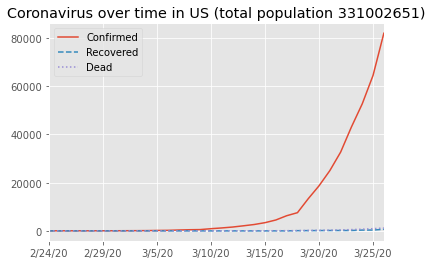

In [90]:
display_measurements(measurements, populations, data_config['country'])

If you plot an early country, you can clearly see the point at which the behavior change caused an inflection point in infections.

In [91]:
fit_data = {**prior_data, **{
    ## Parameters
    'y':measurements.to_numpy(),
    'T':day_count,
    'ts':list(range(0, day_count)),
    'population':populations[data_config['country']],
}}

In [92]:
fit_model = cmdstanpy.CmdStanModel(stan_file=data_config['model_file'])

fit = fit_model.sample(data=fit_data,
                               show_progress='notebook',
                               # Use a fixed seed so that our runs are deterministic.
                               seed=2222,
                               # This computer has 24 cores/48 threads; 24 chains is plenty
                               cores=24,
                               chains=24,
                               # Make the sampler a bit more robust in exchange for more sampling time
                               # adapt_delta=0.9,
                               # Let the sampler explore deeper
                               max_treedepth=16,
                               # Make sure to get enough samples to avoid any diagnostic problems
                               iter_sampling=300)

# Generate a run summary
samples.run_validate_stan(fit, important_values)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/peddie/programming/covid19-modelling/sird_discrete


INFO:cmdstanpy:Processing csv files: /tmp/tmpfwdi92do/sird_discrete-202003291517-1-ic_3nulx.csv, /tmp/tmpfwdi92do/sird_discrete-202003291517-2-zhlswq4v.csv, /tmp/tmpfwdi92do/sird_discrete-202003291517-3-90kb010h.csv, /tmp/tmpfwdi92do/sird_discrete-202003291517-4-ru98fnio.csv, /tmp/tmpfwdi92do/sird_discrete-202003291517-5-3vmldfdc.csv, /tmp/tmpfwdi92do/sird_discrete-202003291517-6-vxex_8nb.csv, /tmp/tmpfwdi92do/sird_discrete-202003291517-7-cmcofc03.csv, /tmp/tmpfwdi92do/sird_discrete-202003291517-8-6uayr7rg.csv, /tmp/tmpfwdi92do/sird_discrete-202003291517-9-3m_g1ljv.csv, /tmp/tmpfwdi92do/sird_discrete-202003291517-10-77xz34bo.csv, /tmp/tmpfwdi92do/sird_discrete-202003291517-11-7v3vmp2w.csv, /tmp/tmpfwdi92do/sird_discrete-202003291517-12-kzsv2_1c.csv, /tmp/tmpfwdi92do/sird_discrete-202003291517-13-kkuutchz.csv, /tmp/tmpfwdi92do/sird_discrete-202003291517-14-d8r44y0y.csv, /tmp/tmpfwdi92do/sird_discrete-202003291517-15-8uwr_7c1.csv, /tmp/tmpfwdi92do/sird_discrete-202003291517-16-b5a2lde1.c

Mean          MCSE      StdDev          5%  \
name                                                                
lp__            -536.241000  2.862000e-02    1.636820 -539.436000   
beta               0.248961  3.845610e-06    0.000342    0.248415   
gamma              0.001624  6.810060e-07    0.000053    0.001537   
zeta               0.003428  7.610060e-07    0.000060    0.003329   
sigma_infected  1258.140000  2.420520e+00  191.041000  979.972000   
sigma_dead        27.865600  3.171230e-02    2.514180   24.122400   

                        50%          95%    N_Eff   N_Eff/s     R_hat  
name                                                                   
lp__            -535.916000  -534.246000  3270.86   971.138  1.004360  
beta               0.248951     0.249543  7900.31  2345.650  0.999599  
gamma              0.001623     0.001713  6141.52  1823.460  0.999351  
zeta               0.003428     0.003526  6120.47  1817.210  0.999931  
sigma_infected  1236.080000  1601.980000  6229.28  1849.510  1.000240  
sigma_dead        27.647900    32.240800  6285.46  1866.190  1.002030

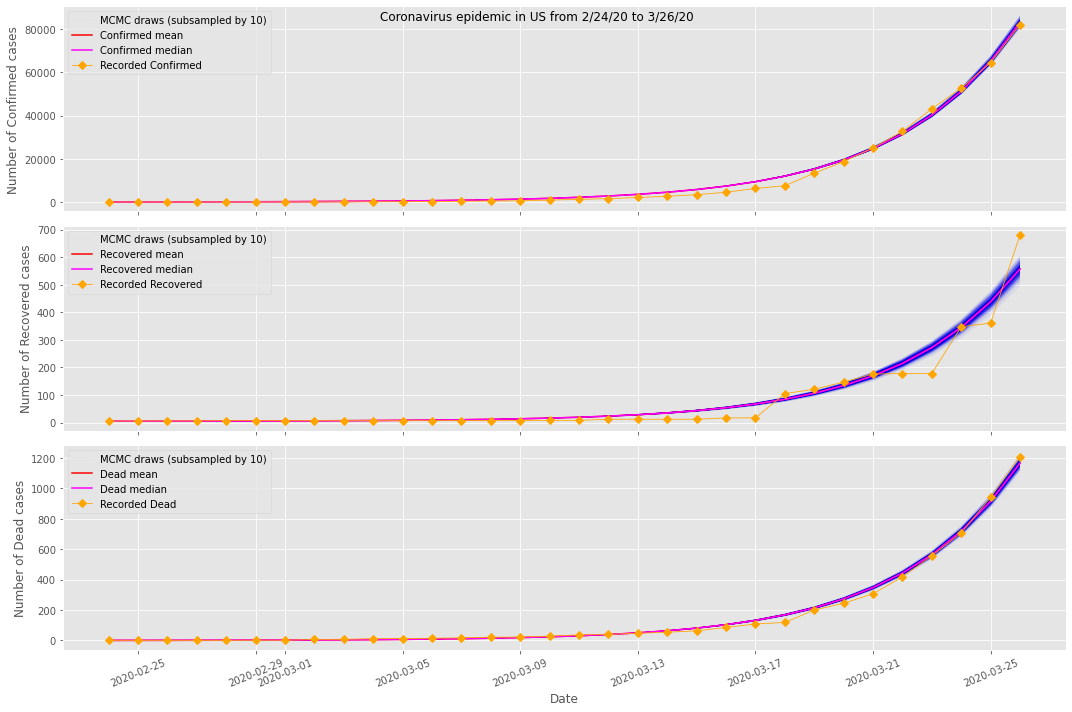

R0 = 0.24896100000000002 / 0.00162367 = 153.3322657929259


(0.24896100000000002, 0.00162367)

In [93]:
fit_samples = samples.get_sample_time_series(fit)
plot_posterior_time_series(fit_samples, measurements, data_config)
sir_r0(fit.summary())

#### Extended prior diagnostics

We'll use arviz to do some more diagnostic plots.

Displaying posterior plots.


/usr/local/lib/python3.8/dist-packages/arviz/plots/backends/matplotlib/pairplot.py:129: MatplotlibDeprecationWarning: In a future version, 'pad' will default to rcParams['figure.subplot.wspace'].  Set pad=0 to keep the old behavior.
  cax = divider.append_axes("left", size="7%")


Validating inference run.


/usr/local/lib/python3.8/dist-packages/arviz/stats/stats.py:531: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


LOO analysis:
 Computed from 7200 by 96 log-likelihood matrix

         Estimate       SE
elpd_loo  -597.18    27.09
p_loo       20.41        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       93   96.9%
 (0.5, 0.7]   (ok)          2    2.1%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    1    1.0%

Validating parameter sampling.


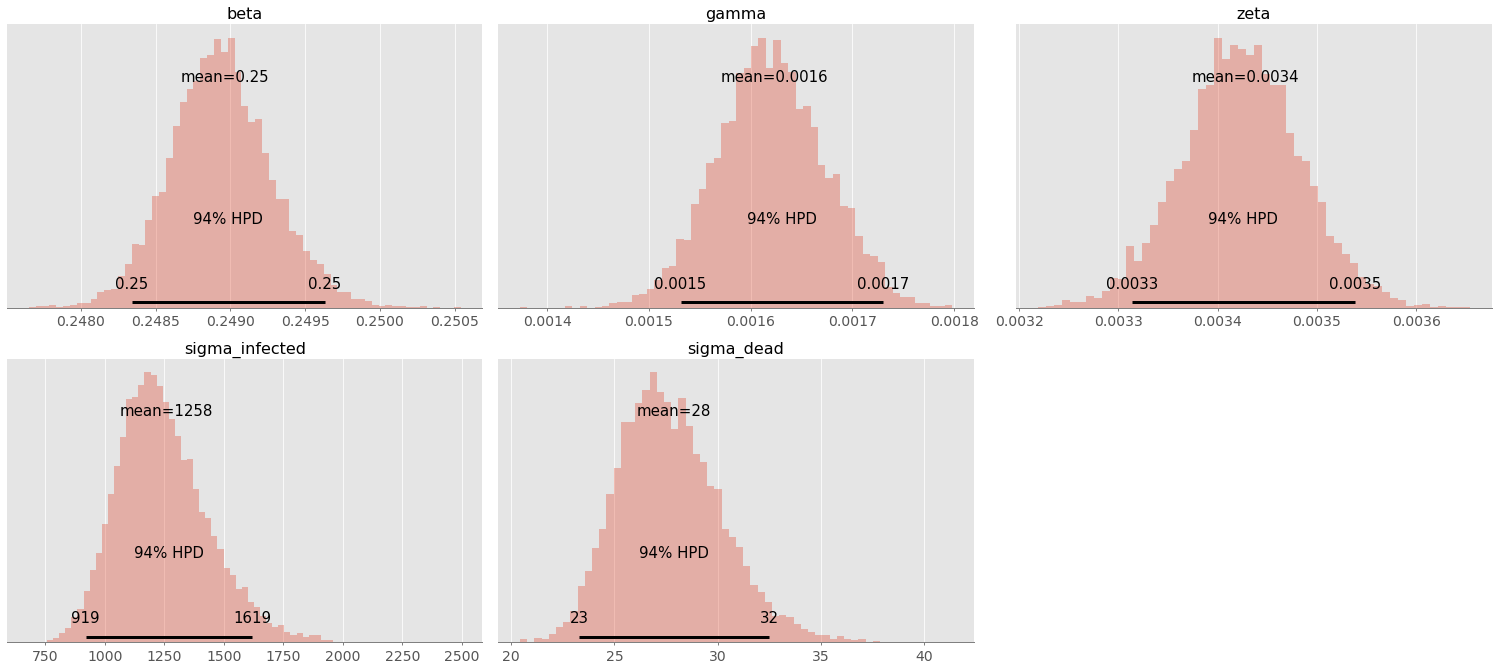

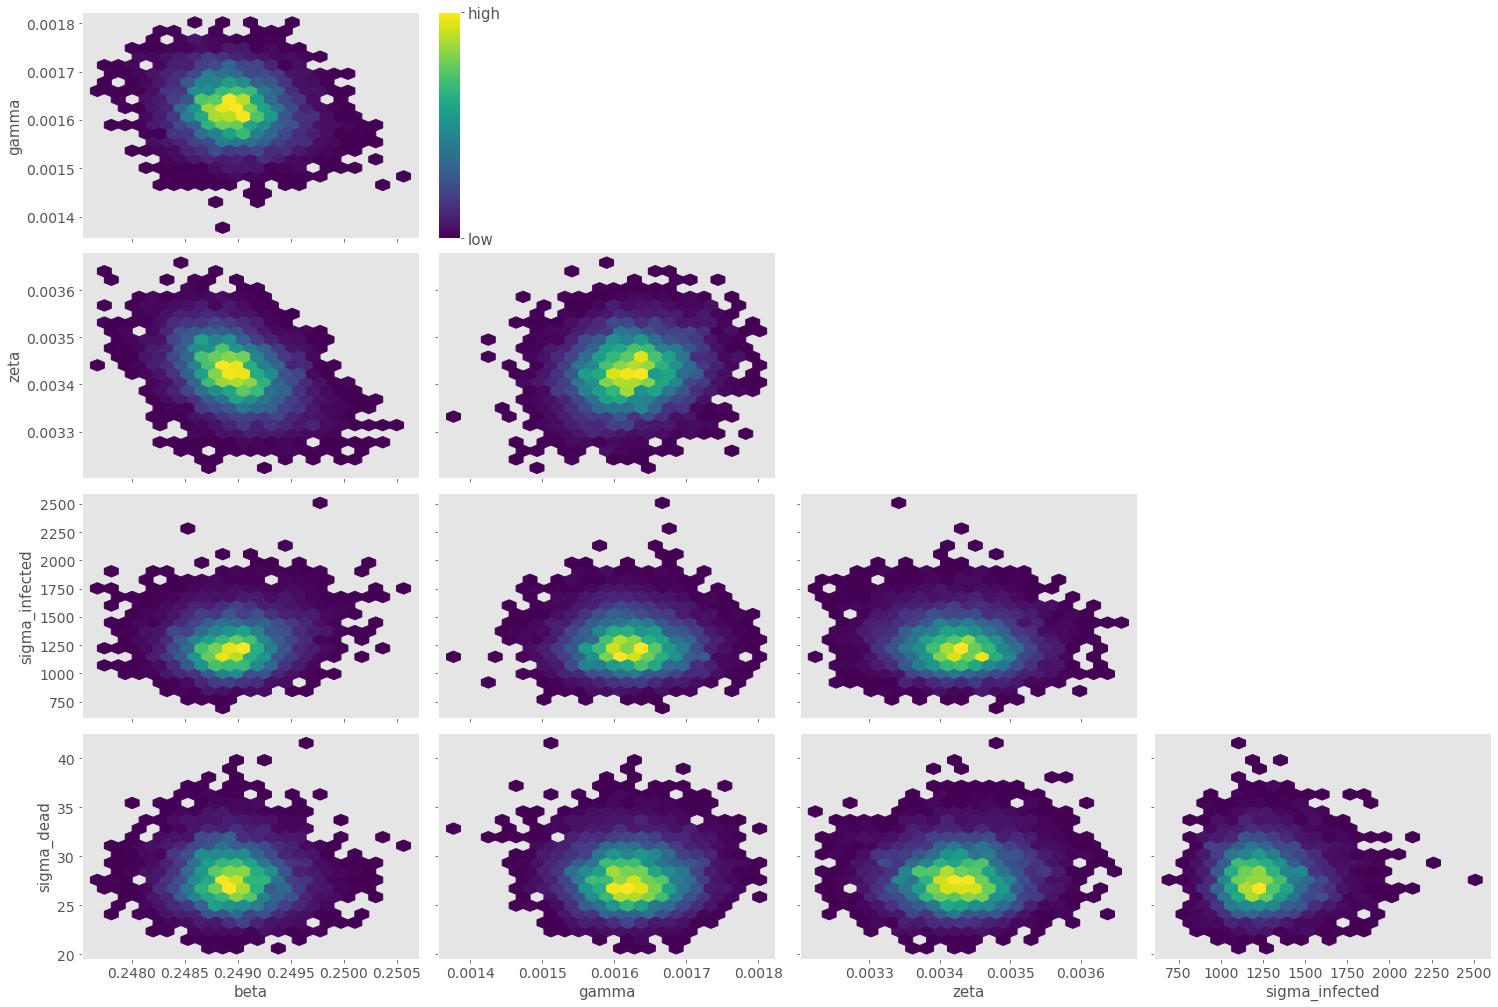

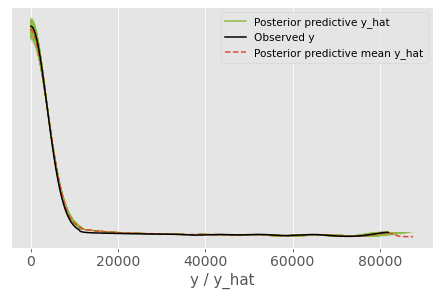

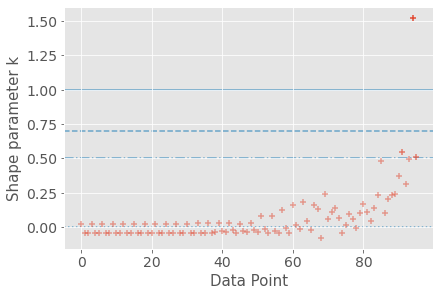

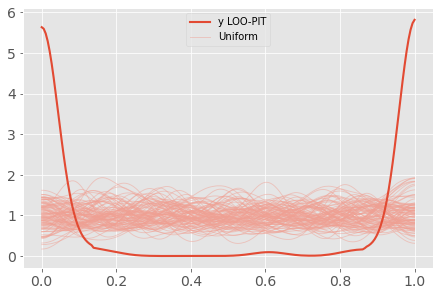

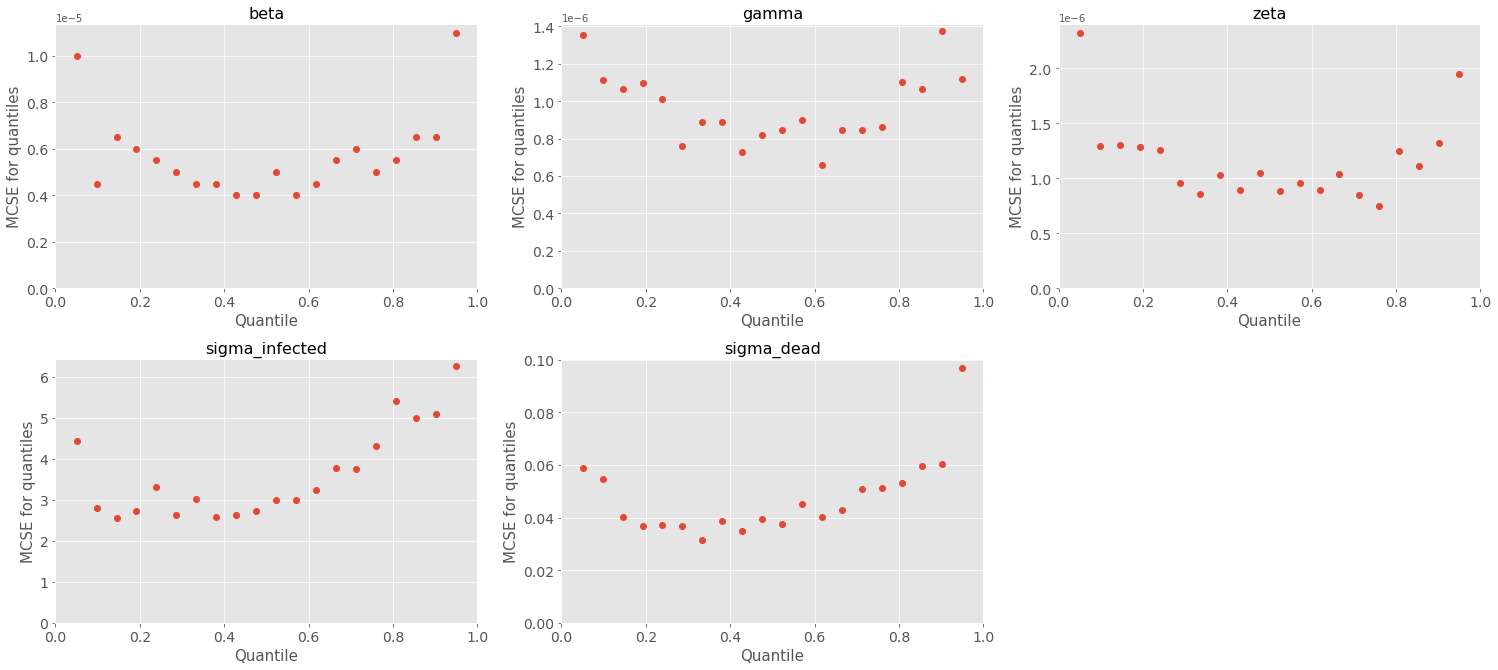

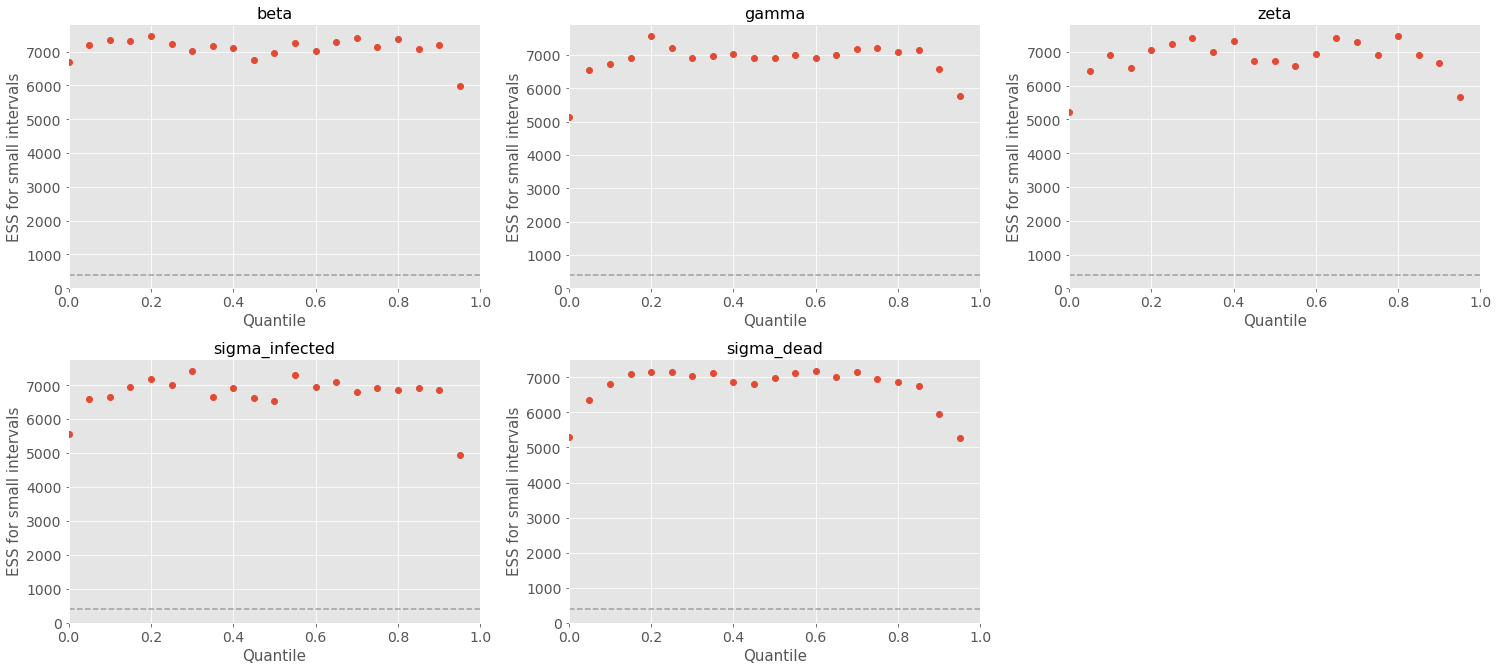

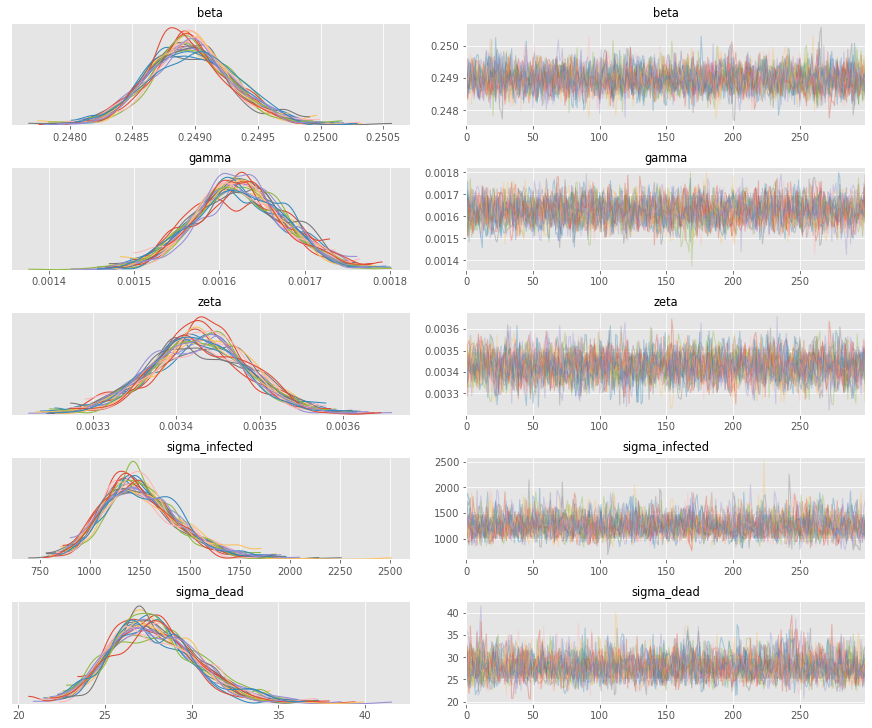

In [94]:
samples.standard_validate_arviz(fit, 'log_likelihood', 'y_hat', measurements.to_numpy(), analysis_variables)

# Summary

We're able to fit US and Australian data no problem.  But you can already see issues.  

## Time-domain behavior

The R0 estimates you get from the standard SIR formula $\frac{\beta}{\gamma}$ are totally nonsensical here, because recoveries can't be declared until someone has run the course of the disease, which typically happens in 2-3 weeks.  This suggests the need for a lag or delay of some kind.

This problem also turns up with deaths -- if you infect 10000 people in one day, none of them will die the next day, and few of them will die within the next week.  With the current model, as fit to US data, 35-40 of those guys will die the next day.

A third problem with the time-domain behavior is the effect of detection on infected cases.  Conditions in hospitals may be bad enough that the infected can continue to spread the infection, but for the most part, we expect infected people to be under quarantine to the extent that they don't propagate the infection.  So really, the most important population for the $\beta$ term in the dynamics equations is the number of _undetected_ infections!

This suggests maybe a discrete-time approach with a convolution so that we can model delay distributions.

## Measurement model

This makes things tougher.  We know for certain that the test figures do not capture the total population of infected people.  This fraction may be near 1 (Singapore) or near 0 (US).  We also know that test figures are pretty unlikely to ever be higher than the true number of infected people.  Rather than this simple symmetric noise model, it seems like the right approach is something like measuring some fraction of infected but uncounted people.  This would require another state plus whatever parameters are needed to model the sampling process.

TODO(MP): We also aren't accounting for recoveries or deaths in the case counts in the current model; the reported figures from countries are simply positive test numbers.

## Quarantine

Haven't tried modeling this yet.